<a href="https://colab.research.google.com/github/AnshGoyal13/time-series-analysis/blob/main/time_series_analysis_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install necessary libraries
!pip install yfinance prophet statsmodels scikit-learn tensorflow --quiet

In [ ]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Step 3: Download stock data
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')
df = df[['Close']].dropna()
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

/tmp/ipython-input-3-3265481841.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Step 4: Define Forecasting Functions
def run_arima(df):
    model = ARIMA(df['y'], order=(5,1,0))
    result = model.fit()
    forecast = result.forecast(steps=30)
    return forecast

def run_sarima(df):
    model = SARIMAX(df['y'], order=(1,1,1), seasonal_order=(1,1,0,12))
    result = model.fit(disp=False)
    forecast = result.forecast(steps=30)
    return forecast

def run_prophet(df):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    return forecast[['ds', 'yhat']].tail(30)

def run_lstm(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df['y'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i])
        y.append(scaled_data[i])
    X, y = np.array(X), np.array(y)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=3, batch_size=32, verbose=0)

    input_seq = scaled_data[-60:]
    lstm_predictions = []
    for _ in range(30):
        pred = model.predict(input_seq.reshape(1, 60, 1), verbose=0)
        lstm_predictions.append(pred[0][0])
        input_seq = np.append(input_seq[1:], pred, axis=0)

    return scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()

In [ ]:
# Step 5: Get forecasts from all models
arima_fc = run_arima(df)
sarima_fc = run_sarima(df)
prophet_fc = run_prophet(df)['yhat']
lstm_fc = run_lstm(df)

# Forecast dates (last 30 days forward)
forecast_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=30)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb0wvemw9/22n9p93r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb0wvemw9/0h89um50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79889', 'data', 'file=/tmp/tmpb0wvemw9/22n9p93r.json', 'init=/tmp/tmpb0wvemw9/0h89um50.json', 'output', 'file=/tmp/tmpb0wvemw9/prophet_model5q53oy38/prophet_model-20250718190509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

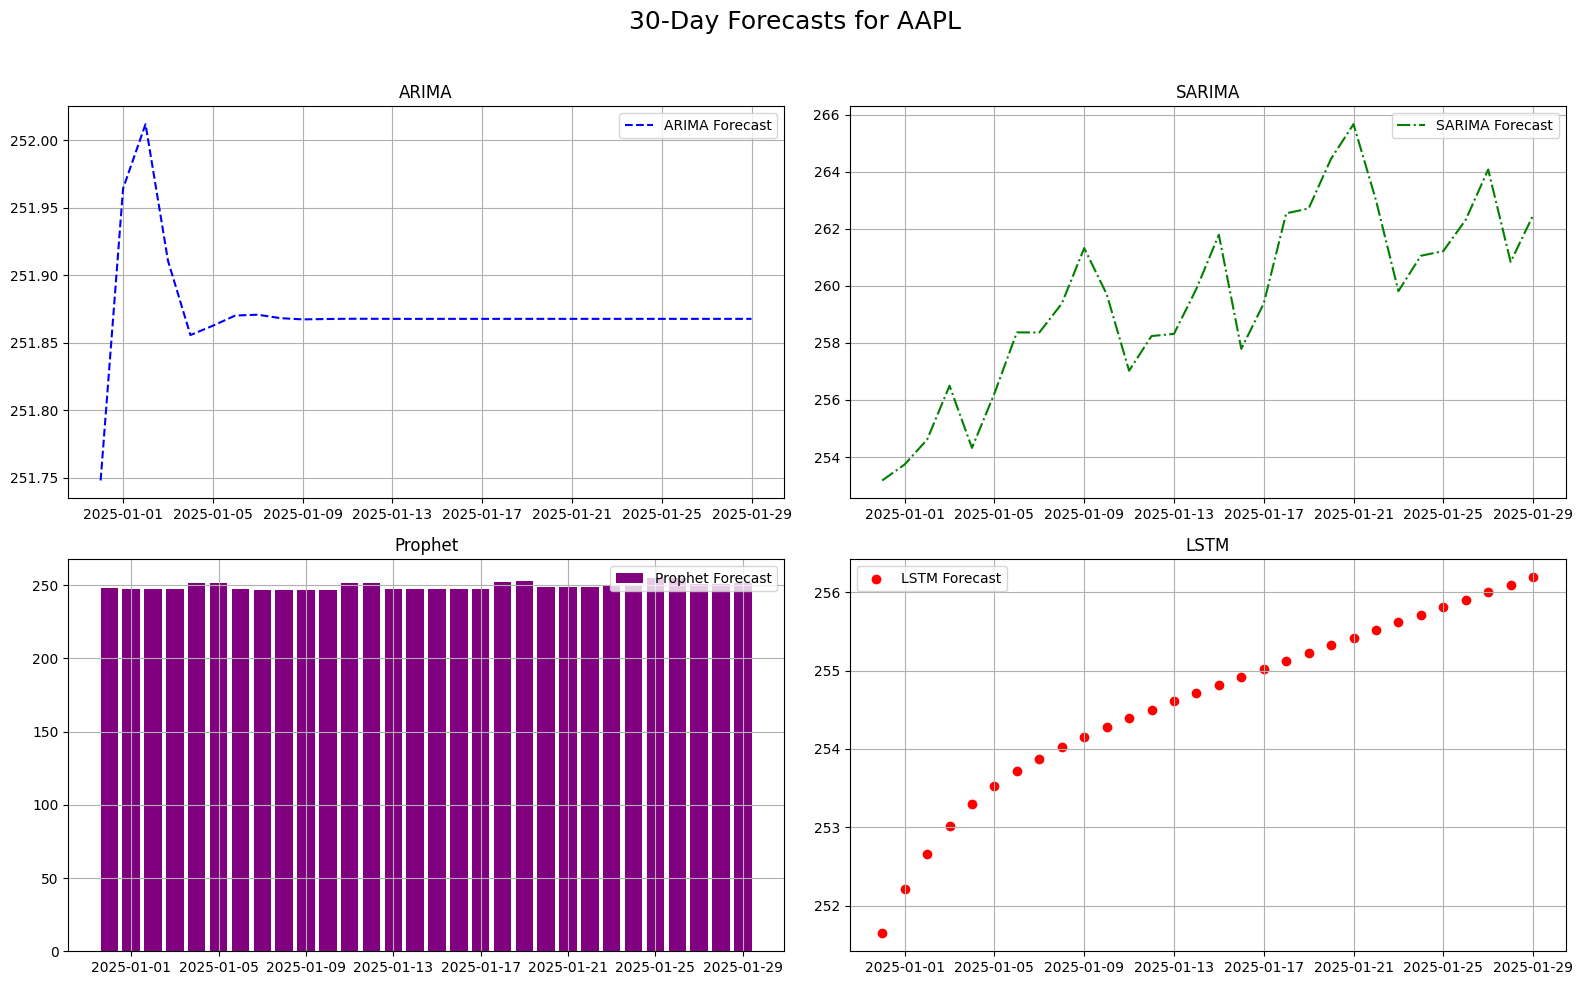

In [ ]:
# Step 6: Plot in 2x2 grid with different styles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"30-Day Forecasts for {ticker}", fontsize=18)

# ARIMA
axes[0, 0].plot(forecast_dates, arima_fc, color='blue', linestyle='--', label='ARIMA Forecast')
axes[0, 0].set_title('ARIMA')
axes[0, 0].legend()
axes[0, 0].grid()

# SARIMA
axes[0, 1].plot(forecast_dates, sarima_fc, color='green', linestyle='-.', label='SARIMA Forecast')
axes[0, 1].set_title('SARIMA')
axes[0, 1].legend()
axes[0, 1].grid()

# Prophet
axes[1, 0].bar(forecast_dates, prophet_fc, color='purple', label='Prophet Forecast')
axes[1, 0].set_title('Prophet')
axes[1, 0].legend()
axes[1, 0].grid()

# LSTM
axes[1, 1].scatter(forecast_dates, lstm_fc, color='red', label='LSTM Forecast')
axes[1, 1].set_title('LSTM')
axes[1, 1].legend()
axes[1, 1].grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()